In [28]:
## Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from time import time
from sklearn.metrics import accuracy_score
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import RidgeClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import GradientBoostingClassifier

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
from cooc import *
from pickle_vocab import *
from preprocessing_final import pre_process
from helpers import *

### Simple models
In this file, we tried to train our model very simply, without advanced techniques to encode the tweets.

In [30]:
## creating training data
full_train=load_data()
full_train.sample(5)

,data,target
93870,"<user> loool ! ! ! oh yeah matt , you should'v...",:)
33713,<user> and ill do the same to you\n,:)
171272,"<user> shut up , you're a 90 student even with...",:(
80411,<user> please vote 4 my film the wall of death...,:)
12444,#yougetmajorpointsif you're great with little ...,:)


In [31]:
full_train.data = pre_process(full_train.data)

In [32]:
## split the data to train the models with 75% of full_train in train and 25% in test
train , test=train_test_split(full_train)

### Bayes Classifier

In [33]:
## Extracting features from text files thanks to count vectorizer
np.random.seed(43)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(train.data)
X_train_counts.shape

(150000, 83996)

In [34]:
## TF-IDF matrix creation

tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf.shape

(150000, 83996)

In [35]:
## Training Naive Bayes (NB) classifier on training data.

clf = MultinomialNB().fit(X_train_tfidf, train.target)

In [36]:
## pipeline for the model 

text_clf = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()), ('clf', MultinomialNB())])
text_clf = text_clf.fit(train.data, train.target)

In [37]:
## predictions

predicted = text_clf.predict(test.data)
print('Accuracy of Naive Bayes CLassifier: ', np.mean(predicted == test.target))

Accuracy of Naive Bayes CLassifier:  0.77118


### SVM

In [38]:
## SVM

text_clf_svm = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                         ('clf-svm', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-5, max_iter=100, random_state=42))])

text_clf_svm = text_clf_svm.fit(train.data, train.target)
predicted_svm = text_clf_svm.predict(test.data)
print('Accuracy of Support Vector Machine model: ',np.mean(predicted_svm == test.target))

Accuracy of Support Vector Machine model:  0.80216


For both models, we got quite good accuracy, especially for SVM. Theses models are interesting as they are very simple and efficient.

### Logistic regression TF-IDF and Count Vectorizer


In [39]:
## logistic regression on TF-IDF and count vectorizer representations

x_train, y_train, x_test, y_test= train.data, train.target, test.data, test.target

def accuracy_summary(pipeline, x_train, y_train, x_test, y_test):
    t0 = time()
    sentiment_fit = pipeline.fit(x_train, y_train)
    y_pred = sentiment_fit.predict(x_test)
    train_test_time = time() - t0
    accuracy = accuracy_score(y_test, y_pred)
    print ("accuracy score: {0:.2f}%".format(accuracy*100))
    print ("train and test time: {0:.2f}s".format(train_test_time))
    print ("-"*80)
    return accuracy, train_test_time

cvec = CountVectorizer()
lr = LogisticRegression(max_iter=1000)
n_features = np.arange(10000,100001,10000)

def nfeature_accuracy_checker(vectorizer=cvec, n_features=n_features, stop_words=None, ngram_range=(1, 1), classifier=lr):
    result = []
    print(classifier)
    print ("\n")
    for n in n_features:
        vectorizer.set_params(stop_words=stop_words, max_features=n, ngram_range=ngram_range)
        checker_pipeline = Pipeline([('vectorizer', vectorizer),('classifier', classifier)])
        print ("Validation result for {} features".format(n))
        nfeature_accuracy,tt_time = accuracy_summary(checker_pipeline, x_train, y_train, x_test, y_test)
        result.append((n,nfeature_accuracy,tt_time))
    
    return result

tvec = TfidfVectorizer()

feature_result_ugt = nfeature_accuracy_checker(vectorizer=tvec)
feature_result_bgt = nfeature_accuracy_checker(vectorizer=tvec,ngram_range=(1, 2))
feature_result_tgt = nfeature_accuracy_checker(vectorizer=tvec,ngram_range=(1, 3))

LogisticRegression(max_iter=1000)


Validation result for 10000 features
accuracy score: 80.00%
train and test time: 11.31s
--------------------------------------------------------------------------------
Validation result for 20000 features
accuracy score: 80.14%
train and test time: 11.40s
--------------------------------------------------------------------------------
Validation result for 30000 features
accuracy score: 80.18%
train and test time: 10.39s
--------------------------------------------------------------------------------
Validation result for 40000 features
accuracy score: 80.22%
train and test time: 24.65s
--------------------------------------------------------------------------------
Validation result for 50000 features
accuracy score: 80.20%
train and test time: 9.32s
--------------------------------------------------------------------------------
Validation result for 60000 features
accuracy score: 80.23%
train and test time: 10.21s
--------------------------------

In [12]:
feature_result_ug = nfeature_accuracy_checker(vectorizer=cvec)
feature_result_bg = nfeature_accuracy_checker(vectorizer=cvec,ngram_range=(1, 2))
feature_result_tg  = nfeature_accuracy_checker(vectorizer=cvec,ngram_range=(1, 3))

LogisticRegression(max_iter=1000)


Validation result for 10000 features
accuracy score: 80.10%
train and test time: 18.64s
--------------------------------------------------------------------------------
Validation result for 20000 features
accuracy score: 80.30%
train and test time: 19.61s
--------------------------------------------------------------------------------
Validation result for 30000 features
accuracy score: 80.37%
train and test time: 20.12s
--------------------------------------------------------------------------------
Validation result for 40000 features
accuracy score: 80.41%
train and test time: 22.46s
--------------------------------------------------------------------------------
Validation result for 50000 features
accuracy score: 80.41%
train and test time: 23.42s
--------------------------------------------------------------------------------
Validation result for 60000 features
accuracy score: 80.39%
train and test time: 24.89s
-------------------------------

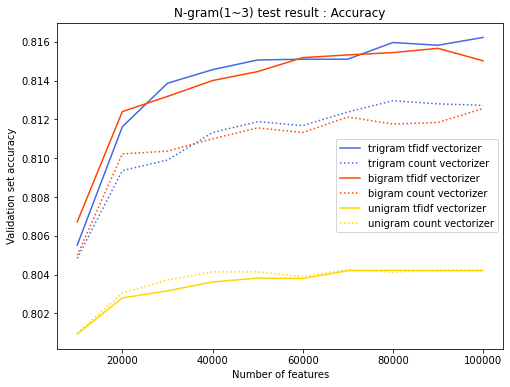

In [13]:
## visualization of the n-gram tfidf vectorizer and n-gram count vectorizer, for different values of n

nfeatures_plot_tgt = pd.DataFrame(feature_result_tgt,columns=['nfeatures','validation_accuracy','train_test_time'])
nfeatures_plot_bgt = pd.DataFrame(feature_result_bgt,columns=['nfeatures','validation_accuracy','train_test_time'])
nfeatures_plot_ugt = pd.DataFrame(feature_result_ugt,columns=['nfeatures','validation_accuracy','train_test_time'])
nfeatures_plot_tg = pd.DataFrame(feature_result_tg,columns=['nfeatures','validation_accuracy','train_test_time'])
nfeatures_plot_bg = pd.DataFrame(feature_result_bg,columns=['nfeatures','validation_accuracy','train_test_time'])
nfeatures_plot_ug = pd.DataFrame(feature_result_ug,columns=['nfeatures','validation_accuracy','train_test_time'])
plt.figure(figsize=(8,6))
plt.plot(nfeatures_plot_tgt.nfeatures, nfeatures_plot_tgt.validation_accuracy,label='trigram tfidf vectorizer',color='royalblue')
plt.plot(nfeatures_plot_tg.nfeatures, nfeatures_plot_tg.validation_accuracy,label='trigram count vectorizer',linestyle=':', color='royalblue')
plt.plot(nfeatures_plot_bgt.nfeatures, nfeatures_plot_bgt.validation_accuracy,label='bigram tfidf vectorizer',color='orangered')
plt.plot(nfeatures_plot_bg.nfeatures, nfeatures_plot_bg.validation_accuracy,label='bigram count vectorizer',linestyle=':',color='orangered')
plt.plot(nfeatures_plot_ugt.nfeatures, nfeatures_plot_ugt.validation_accuracy, label='unigram tfidf vectorizer',color='gold')
plt.plot(nfeatures_plot_ug.nfeatures, nfeatures_plot_ug.validation_accuracy, label='unigram count vectorizer',linestyle=':',color='gold')
plt.title("N-gram(1~3) test result : Accuracy")
plt.xlabel("Number of features")
plt.ylabel("Validation set accuracy")
plt.legend()
plt.show()

As we can see, the validation set accuracy is much lower for unigram tfidf and count vectorizer. 
However, for bi- and tri-gram vectorizers, the accuracies are way higher and increase for an increase in the number of features.

In [91]:
with open('twitter-datasets/test_data.txt') as f:
    real_test = f.readlines()
        
real_test={'data':real_test}
real_test=pd.DataFrame(real_test)

In [93]:
real_test.data=pre_process(real_test.data)

In [94]:
vectorizer = TfidfVectorizer()
lr = LogisticRegression(max_iter=1000)
vectorizer.set_params(stop_words=None, max_features=100000, ngram_range=(1,3))
checker_pipeline = Pipeline([('vectorizer', vectorizer),('classifier', lr)])
sentiment_fit = checker_pipeline.fit(full_train.data, full_train.target)

In [95]:
y_pred = sentiment_fit.predict(real_test.data)

In [96]:
y_pred

array([':(', ':(', ':(', ..., ':(', ':)', ':('], dtype=object)

### Other models with TF-IDF

In [14]:
## training of several simple models of names in 'names'
names = ["Linear SVC", "LinearSVC with L1-based feature selection", 
         "Bernoulli NB", "Ridge Classifier", "Nearest Centroid"]
classifiers = [
    LinearSVC(),
    Pipeline([
  ('feature_selection', SelectFromModel(LinearSVC(penalty="l1", dual=False))),
  ('classification', LinearSVC(penalty="l2"))]),
    BernoulliNB(),
    RidgeClassifier(),
    NearestCentroid(),
   ]

zipped_clf = zip(names,classifiers)
n=90000

tvec = TfidfVectorizer()

In [15]:
def classifier_comparator(vectorizer=tvec, n_features=10000, stop_words=None, ngram_range=(1, 1), classifier=zipped_clf):
    result = []
    vectorizer.set_params(stop_words=stop_words, max_features=n_features, ngram_range=ngram_range)
    for n,c in classifier:
        checker_pipeline = Pipeline([
            ('vectorizer', vectorizer),
            ('classifier', c)
        ])
        print ("Validation result for {}".format(n))
        print (c)
        clf_accuracy,tt_time = accuracy_summary(checker_pipeline, x_train, y_train, x_test, y_test)
        result.append((n_features,clf_accuracy,tt_time))
    return result

In [16]:
trigram_result = classifier_comparator(n_features=100000,ngram_range=(1,3))

Validation result for Linear SVC
LinearSVC()
accuracy score: 80.69%
train and test time: 22.89s
--------------------------------------------------------------------------------
Validation result for LinearSVC with L1-based feature selection
Pipeline(steps=[('feature_selection',
                 SelectFromModel(estimator=LinearSVC(dual=False,
                                                     penalty='l1'))),
                ('classification', LinearSVC())])
accuracy score: 80.87%
train and test time: 43.67s
--------------------------------------------------------------------------------
Validation result for Bernoulli NB
BernoulliNB()
accuracy score: 78.16%
train and test time: 20.36s
--------------------------------------------------------------------------------
Validation result for Ridge Classifier
RidgeClassifier()
accuracy score: 81.21%
train and test time: 22.79s
--------------------------------------------------------------------------------
Validation result for Nearest Cent

## Create submission

In [86]:
real_test.index

RangeIndex(start=0, stop=100000, step=1)

In [99]:
import re
ids=[]   
for i in range (real_test.shape[0]):
    text=real_test.data[i]
    found=re.findall('\d+', text )
    ids.append(found[0])

In [100]:
OUTPUT_PATH = 'sample_submission.csv' 
create_csv_submission(ids, y_pred, OUTPUT_PATH)